# AI2C Robust, Reliable and Explainable - Use case with UNSW-NB15
#### AFC-AI2C Pre-Proposal
###### Authors
* Nandita Rahman
* Marissa McKee


In [1]:
# # Install required packages from PyPi Note: After installing these packages you will need to restart your notebook kernel
# !pip install sklearn
# !pip install xgboost
# !pip install aif360['all']
# !pip install wrapt
# !pip install fairlearn
# !pip install BlackBoxAuditing
# !pip install lime
# !pip install -U imbalanced-learn
# !pip install statsmodels
# conda install -c conda-forge imbalanced-learn
# !pip install seaborn --user
# !pip install chart_studio --user
# !pip install aif360['all'] --user
# !pip install plotly --user
# !pip install Minio --user

In [2]:
# Must be imported before importing other libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn import metrics, neighbors

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./input'):
    for filename in filenames:
        if '.csv' in filename:
            print(os.path.join(dirname, filename))
            %matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Any results you write to the current directory are saved as output.
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from datetime import date
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tqdm import tqdm
import seaborn as sns
import datetime
import imblearn
from imblearn.over_sampling import SMOTE, RandomOverSampler
import boto3
import numba
import shap
import minio
from minio import Minio


#visualization libraries 
import seaborn as sns
from plotly import tools
import chart_studio.plotly  as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import warnings
init_notebook_mode(connected=True)

#TAP libraries
from tap.trustworthy import mlobject,robust #if you receive a warning for tensorflow to enable adversarial debiasing you can ignore it


#modeling libraries
import sklearn
from sklearn import metrics, neighbors
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier

import xgboost as xgb # needs testing


import aif360
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric
from aif360.sklearn.metrics import disparate_impact_ratio, statistical_parity_difference
from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.sklearn.inprocessing import AdversarialDebiasing
from aif360.algorithms.postprocessing.calibrated_eq_odds_postprocessing import CalibratedEqOddsPostprocessing


./input/raw/raw_features.csv
./input/raw/list_events.csv
./input/data-preprocessing/importance.csv
./input/data-preprocessing/test.csv
./input/data-preprocessing/features.csv
./input/data-preprocessing/train.csv


# 1. UNSW-NB15 network data set: a comprehensive data set for network intrusion detection systems


### Problem statement

In the cyber security field, an Intrusion Detection System (IDS) is essential for achieving a solid line of defense against cyber intrusions. One of the major research challenges in this field is the unavailability of a comprehensive network based data set which can reflect modern network traffic scenarios, vast varieties of low footprint intrusions and depth structured information about the network traffic. Evaluating network intrusion detection systems research efforts, KDD98, KDDCUP99 and NSLKDD benchmark data sets were generated a decade ago. However, numerous current studies showed that for the current network threat environment, these data sets do not inclusively reflect network traffic and modern low footprint attacks. An intrusion detection system has become a vital mechanism to detect a wide variety of malicious activities in the cyber domain. However, this system still faces an important limitation when it comes to detecting zero-day attacks, concerning the reduction of relatively high false alarm rates (Moustafa, 2017). 

### The Dataset 
Countering the unavailability of network benchmark data set challenges, this tutorial examines a UNSW-NB15 data set creation. This data set has a hybrid of the real modern normal and the contemporary synthesized attack activities of the network traffic. The raw network packets of the UNSW-NB 15 dataset was created by the IXIA PerfectStorm tool in the Cyber Range Lab of UNSW Canberra for generating a hybrid of real modern normal activities and synthetic contemporary attack behaviours. The tcpdump tool was utilised to capture 100 GB of the raw traffic (e.g., Pcap files). This data set is available for research purposes and can be accessed from the link.

Source: https://research.unsw.edu.au/projects/unsw-nb15-dataset


#### Full Dataset
The total number of records is two million and 540,044 which are stored in the four CSV files: 
* UNSW-NB15_1.csv
* UNSW-NB15_2.csv
* UNSW-NB15_3.csv
* UNSW-NB15_4.csv.

#### Ground truth, features, event (description) files

The Argus, Bro-IDS tools are used and twelve algorithms are developed to generate totally 49 features with the class label. 
* These features are described in UNSW-NB15_features.csv file.
* The ground truth table is named 'UNSW-NB15_GT.csv'
* List of event file is called 'UNSW-NB15_LIST_EVENTS.csv

#### Data Partition (Used in this tutorial) 
A partition from this dataset was configured as a training set and testing set, namely, 'train.csv' and 'test.csv' respectively.

* The dataset contains raw network packets and use labels for different types, attack and normal.
* It contains nine different attacks, includes DoS, worms, Backdoors, and Fuzzers
* The number of records in the training set is 175,341
* The number of records in the testing set is 82,332


### Trustworthy AI Framework Tools: Robust and Reliable

#### Git Repo:
https://github.com/Deloitte/aiops-package/tree/master/aiops/trustworthy

#### Application to USNW-NB15
Existing and novel methods are utilised to generate the features of the UNSWNB15 data set. This is a widely known classification problem in the defense space where we want to detect whether intrusions are attacks, and what type. More importantly, reduction in the frequency of false-positives is of high concern.  Deloitte's Trustworthy AI Framework is an early step in our efforts to ensure that AI products and models we deliver are both functional and ethical. Our teams are working to implement features that allow TAP users to easily assess their work along multiple dimensions.Furthermore, we want to drive home the importance of understandability in decision-making models and will highlight utility of TAP’s outputs. This tutorial will survey several widely used models such as Randomforest, Xgboost, Linear-Regression we will present a scalable framework for evaluating a model use-case for anomaly detection systems.

#### What model evaluation metrics are apart of the robust and reliable module? 
The robust package contains several metrics that help data scientists evaluate their model's results. 
- _Accuracy_: percentage of correct predictions.
- _Recall:_ percentage of correct positive predictions compared to all actual positive classifications.
- _Precision:_ percentage of correct positive predictions compared to all positive predictions.
- _Specificity:_ true negative rate and measures to how accurately the negative class is predicted.
- _F1-Score:_ harmonic average of the Recall and Precision. F1 implicitly gives equal weight to Recall and Precision
- _AUC Score:_ AUC provides an aggregate measure of performance across all possible classification thresholds. 


#### Why are these metrics important?
- Model evaluation is an integral part of the model development process. 
- Robust and reliable evaluation metrics can aid in finding the best model that represents your data

## 1.1a Previous Work:

### Additional feature down-selection, EDA and Data-preprocessing have already been conducted and links will be added here

In [32]:
# Load UNSW data
# download data to local from TAP artifact store via client
#-----------------------------------------------------------#
client = Minio(
        "minio-service.kubeflow.svc.cluster.local:9000",
        access_key="admin",
        secret_key="AV9%6ymFo2u^",
        secure=False)
bucket="tai-experiments"

# Training
path="unsw/train.csv"
data= client.get_object(bucket_name=bucket, object_name=path)
train = pd.read_csv(data, index_col=0) # Load data and munge for modeling

# Testing
path="unsw/test.csv"
data = client.get_object(bucket_name=bucket, object_name=path)
test = pd.read_csv(data) # Load data and munge for modeling

# Features
path="unsw/features.csv"
data = client.get_object(bucket_name=bucket, object_name=path)
features = pd.read_csv(data) # Load data and munge for modeling

# Importance
path="unsw/importance.csv"
data = client.get_object(bucket_name=bucket, object_name=path)
importance = pd.read_csv(data) # Load data and munge for modeling

# Event-lists
path="unsw/UNSW-NB15_LIST_EVENTS.csv"
data = client.get_object(bucket_name=bucket, object_name=path)
list_events = pd.read_csv(data) # Load data and munge for modeling


In [33]:
# Optional if prefer to pull data locally
# root = "input/data-preprocessing/"
# train = pd.read_csv(root+"test.csv")
# test = pd.read_csv(root+"train.csv")
# list_events = pd.read_csv(root+"list_events.csv")
# features = pd.read_csv(root+"raw_features.csv", encoding='cp1252')

## 1.1b Utilities

In [34]:
def standardize(df):
    return (df-df.mean())/df.std()
    
def min_max(df):
    return (df-df.min())/(df.max() - df.min())

def normalize(df):
    return pd.Dataframe(preprocessing.normalize(df), columns=df.columns)

# 1.1c USNW-NB15 Data Dictionary
*Add data dictionary*

# 2. Data Inspection, Preparation

In [35]:
train.shape
train.describe()
train.head()

(175341, 53)

,sjit,proto_udp,sload,proto_others,ct_srv_src,tcprtt,dload,state_REQ,swin,dinpkt,...,service_smtp,state_others,ct_dst_sport_ltm,dur,sloss,state_RST,dmean,rate,state_INT,label
count,1.753410e+05,175341.000000,1.753410e+05,175341.000000,1.753410e+05,1.753410e+05,1.753410e+05,175341.000000,1.753410e+05,1.753410e+05,...,175341.000000,175341.000000,1.753410e+05,1.753410e+05,1.753410e+05,175341.000000,1.753410e+05,1.753410e+05,175341.000000,175341.000000
mean,5.024911e-17,0.360914,4.538630e-17,0.151841,5.965056e-17,6.872782e-17,1.426426e-17,0.011355,2.334152e-17,2.382781e-17,...,0.028847,0.000086,3.630904e-17,1.815452e-17,3.776788e-17,0.000473,-1.815452e-17,-3.241878e-17,0.469229,0.680622
std,1.000003e+00,0.480267,1.000003e+00,0.358868,1.000003e+00,1.000003e+00,1.000003e+00,0.105954,1.000003e+00,1.000003e+00,...,0.167376,0.009249,1.000003e+00,1.000003e+00,1.000003e+00,0.021752,1.000003e+00,1.000003e+00,0.499054,0.466237
min,-1.106677e-01,0.000000,-3.899726e-01,0.000000,-7.759906e-01,-5.216596e-01,-2.772081e-01,0.000000,-9.154073e-01,-8.937003e-02,...,0.000000,0.000000,-5.543732e-01,-2.097747e-01,-7.503992e-02,0.000000,-4.807028e-01,-5.768192e-01,0.000000,0.000000
25%,-1.106677e-01,0.000000,-3.899033e-01,0.000000,-6.825702e-01,-5.216596e-01,-2.772081e-01,0.000000,-9.154073e-01,-8.937003e-02,...,0.000000,0.000000,-5.543732e-01,-2.097735e-01,-7.503992e-02,0.000000,-4.807028e-01,-5.766210e-01,0.000000,0.000000
50%,-1.106677e-01,0.000000,-3.853023e-01,0.000000,-4.023091e-01,-5.216596e-01,-2.766105e-01,0.000000,-9.154073e-01,-8.936395e-02,...,0.000000,0.000000,-5.543732e-01,-2.095306e-01,-7.503992e-02,0.000000,-3.103690e-01,-5.573162e-01,0.000000,1.000000
75%,-5.477415e-02,1.000000,8.194472e-02,0.000000,2.516337e-01,3.035188e-01,-2.657082e-01,0.000000,1.092456e+00,-3.764934e-02,...,0.000000,0.000000,-2.085659e-01,-1.066813e-01,-2.958873e-02,0.000000,-1.361640e-01,1.789221e-01,1.000000,1.000000
max,3.236919e+01,1.000000,3.140074e+01,1.000000,5.016074e+00,3.122093e+01,8.983387e+00,1.000000,1.092456e+00,5.736922e+01,...,1.000000,1.000000,7.226290e+00,9.049154e+00,7.269232e+01,1.000000,5.163540e+00,5.469112e+00,1.000000,1.000000


,sjit,proto_udp,sload,proto_others,ct_srv_src,tcprtt,dload,state_REQ,swin,dinpkt,...,service_smtp,state_others,ct_dst_sport_ltm,dur,sloss,state_RST,dmean,rate,state_INT,label
ct_state_ttl,,,,,,,,,,,,,,,,,,,,,
-1.366486,-0.109997,0,-0.389897,0,-0.775991,-0.521660,-0.273700,0,1.092456,-0.080885,...,0,0,-0.554373,-0.191029,-0.075040,0,-0.314240,-0.576371,0,0
-0.318711,-0.109302,0,-0.389928,0,3.147666,-0.521660,-0.069233,0,1.092456,-0.073735,...,0,0,-0.554373,-0.109485,-0.044739,0,3.800869,-0.576345,0,0
-0.318711,0.271392,0,-0.389964,0,-0.215468,0.888444,-0.252044,0,1.092456,0.014711,...,0,0,-0.554373,0.040699,-0.059890,0,2.709185,-0.576734,0,0
-0.318711,-0.104906,0,-0.389958,0,-0.775991,-0.521660,-0.275821,0,1.092456,0.002046,...,0,0,-0.554373,0.049729,-0.059890,0,-0.232945,-0.576737,0,0
-0.318711,-0.056942,0,-0.389927,0,3.147666,1.096172,-0.275561,0,1.092456,-0.012721,...,0,0,-0.554373,-0.140417,-0.044739,0,-0.306498,-0.576617,0,0


In [36]:
test.shape
test.describe()

(82332, 54)

,ct_state_ttl,sjit,proto_udp,sload,proto_others,ct_srv_src,tcprtt,dload,state_REQ,swin,...,service_smtp,state_others,ct_dst_sport_ltm,dur,sloss,state_RST,dmean,rate,state_INT,label
count,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,...,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000
mean,0.068204,0.030842,0.357309,-0.047277,0.098698,0.022436,0.183097,-0.016792,0.022373,0.135446,...,0.022482,0.000061,-0.093929,-0.054417,-0.003020,0.000012,-0.030576,-0.078569,0.414942,0.550600
std,1.118173,1.261495,0.479210,0.954899,0.298258,1.036059,1.462083,0.988310,0.147894,1.002806,...,0.148246,0.007793,1.022792,0.726895,0.979467,0.003485,0.946902,0.898548,0.492715,0.497436
min,-1.366486,-0.110668,0.000000,-0.389973,0.000000,-0.775991,-0.521660,-0.277208,0.000000,-0.915407,...,0.000000,0.000000,-0.554373,-0.209775,-0.075040,0.000000,-0.480703,-0.576819,0.000000,0.000000
25%,-0.318711,-0.110668,0.000000,-0.389913,0.000000,-0.682570,-0.521660,-0.277208,0.000000,-0.915407,...,0.000000,0.000000,-0.554373,-0.209774,-0.075040,0.000000,-0.480703,-0.576646,0.000000,0.000000
50%,-0.318711,-0.110276,0.000000,-0.386909,0.000000,-0.402309,-0.514716,-0.276335,0.000000,1.092456,...,0.000000,0.000000,-0.554373,-0.207593,-0.059890,0.000000,-0.310369,-0.560796,0.000000,1.000000
75%,0.729064,-0.039072,1.000000,-0.044125,0.000000,0.158213,0.808344,-0.270659,0.000000,1.092456,...,0.000000,0.000000,-0.208566,-0.098766,-0.029589,0.000000,-0.143906,0.094951,1.000000,1.000000
max,4.920164,32.888492,1.000000,27.578209,1.000000,5.016074,47.635677,8.321917,1.000000,1.092456,...,1.000000,1.000000,5.843061,9.049154,80.509923,1.000000,5.326131,5.469112,1.000000,1.000000


(45, 3)

,Name,Type,Description
count,45,45,45
unique,45,7,45
top,ct_dst_src_ltm,integer,Source interpacket arrival time (mSec)
freq,1,18,1


,Name,Type,Description
0,proto,nominal,Transaction protocol
1,state,nominal,Indicates to the state and its dependent proto...
2,dur,Float,Record total duration
3,sbytes,Integer,Source to destination transaction bytes
4,dbytes,Integer,Destination to source transaction bytes
5,sttl,Integer,Source to destination time to live value
6,dttl,Integer,Destination to source time to live value
7,sloss,Integer,Source packets retransmitted or dropped
8,dloss,Integer,Destination packets retransmitted or dropped
9,service,nominal,"http, ftp, smtp, ssh, dns, ftp-data ,irc and ..."


<Figure size 1296x360 with 0 Axes>

<AxesSubplot:>

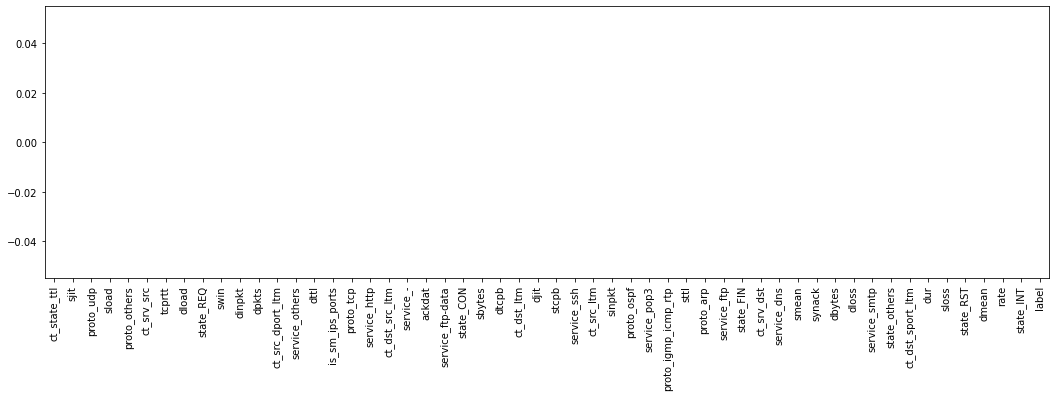

In [37]:
features.shape
features.describe()
features.head(features.shape[0])

plt.figure(figsize = (18,5))
test.isnull().sum().plot(kind='bar',color=sns.color_palette("husl", 8))

In [38]:
#to combine test-train for evaluation

df = pd.concat([test.assign(ind="test"), train.assign(ind="train")])

# to separate again back to original
# test, train = df[df["ind"].eq("test")], df[df["ind"].eq("train")]


## 2.1 Defining Data Scope
Looking at the event list, binning based on Attack category, sub category
    
Records that were removed:
- proto
- rate
- other categorical features
- values that didn't seem applicable

In [39]:
event_list.shape
event_list.head(event_list.shape[0])
event_list['Attack subcategory'].unique()

(208, 2)

,Attack subcategory,Number of events
Attack category,,
normal,NaN,2218761
Fuzzers,FTP,558
Fuzzers,HTTP,1497
Fuzzers,RIP,3550
Fuzzers,SMB,5245
...,...,...
Shellcode,Decoders,18
Shellcode,Multiple OS,10
Shellcode,Solaris,12


array([nan, 'FTP', 'HTTP', 'RIP', 'SMB', 'Syslog', 'PPTP', ' FTP',
       'DCERPC', 'OSPF', 'TFTP', ' DCERPC ', ' OSPF', 'BGP', 'Telnet',
       'SNMP', ' SunRPC Portmapper (TCP) UDP Service',
       ' SunRPC Portmapper (TCP) TCP Service ',
       'SunRPC Portmapper (UDP) UDP Service', 'NetBIOS', 'DNS',
       'SunRPC Portmapper (UDP)', ' ICMP', ' SCTP', 'MSSQL', 'SMTP',
       'FreeBSD', 'HP-UX ', 'NetBSD ', 'AIX', 'SCO Unix', 'Linux',
       'Decoders', 'IRIX', 'OpenBSD', ' Mac OS X', 'BSD', 'Windows',
       'BSDi', 'Multiple OS', 'Solaris', 'HTML', 'Port Scanner', 'Spam ',
       ' ', ' Ethernet', ' Microsoft Office', ' VNC', 'IRC', 'RDP', 'TCP',
       'VNC', ' LDAP', ' Oracle ', ' TCP', ' TFTP', 'XINETD', ' IRC',
       ' SNMP', 'ISAKMP', 'NTP', 'CUPS', 'Hypervisor', 'ICMP', 'SunRPC',
       ' IMAP', 'Asterisk', 'Browser', 'Cisco Skinny', 'SIP', 'SSL',
       ' SMTP', 'IIS Web Server', 'Miscellaneous', 'RTSP',
       ' Common Unix Print System (CUPS)', ' SunRPC', 'IGMP',
       '

<Figure size 1440x936 with 0 Axes>

<AxesSubplot:>

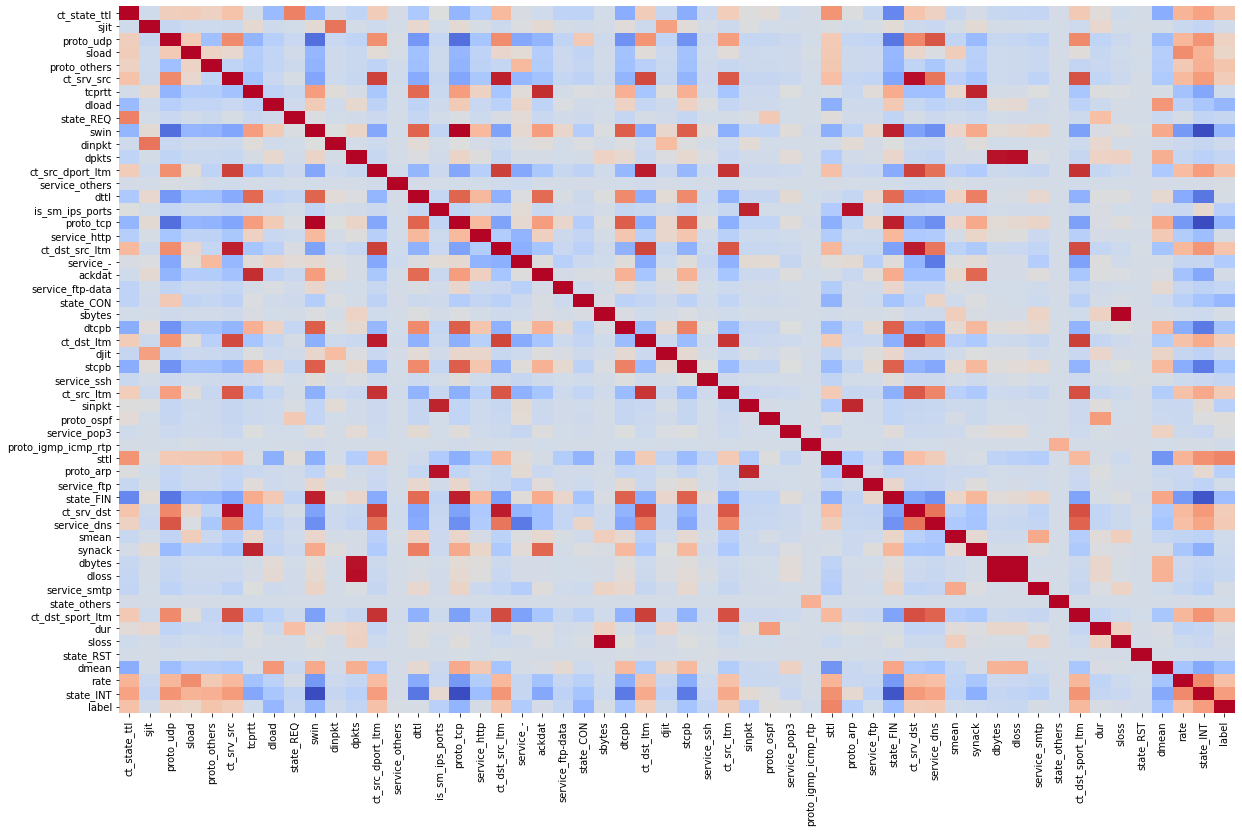

In [40]:
# Plot correlation matrix
plt.figure(figsize=(20,13))
sns.heatmap(df.corr(),
            cmap='coolwarm',
            annot=False,
            fmt=".2f",
            annot_kws={'size':16},
            cbar=False)

## 2.2 Transform into Binary Classification Problem
A new column that translates the loan approval or denial decision will be used as the binary target to classify individuuals who are identified as approved for a mortgage loan.

In [6]:
# Turn into a binary classification problem
df.loc[df.action_taken == 3, 'action_taken'] = 0

## 2.3 Outlier Detection and Handling 
Records that were among the top 2% of loan amount values were classified as outliers and removed to balance the dataset. Similarly, records that were among the top 3% and bottom 1% of income levels were classified as outliers and removed.

In [7]:
# Detect outliers by using quantile threshold
print("Top 2% of loan amounts: ",df['loan_amount'].quantile(.98),"\nBottom 1% of income levels: ",df['income'].quantile(.01),"\nTop 3% of income levels: ",df['income'].quantile(.97))

# Remove the top 2% of loan amount values as they are outliers
df = df[(df['loan_amount']<df['loan_amount'].quantile(.98))]

# Remove the top 3% and the bottom 1% of income values as they are outliers
df = df[(df['income']>df['income'].quantile(.01))&(df['income']<df['income'].quantile(.97))]

Top 2% of loan amounts:  865000.0 
Bottom 1% of income levels:  0.0 
Top 3% of income levels:  319.0


# 3. Feature Selection 
1. Create one model with hand picked features (HUD OG model). 
2. Create one model with features that were chosen using a SHAP feature selection implementation. 
3. Compare both models with TAP robust model evaluation techniques

- ***Need understanding of why these features were selected***: selected by HUD SME
- Do we want to use explainable techniques for feature selection? SHAP feature importance 
    - Compare SHAP feature selection to SME feature selection 
    

In [8]:
columns = [
    'income', 
    'debt_to_income_ratio',
    'loan_to_value_ratio',
    'loan_amount',
    'derived_ethnicity', 
    'derived_race', 
    'derived_sex', 
    'applicant_age',
    'preapproval',
    'loan_type',
    'loan_purpose',
    'interest_only_payment',
    'balloon_payment',
    'action_taken']

df = df[columns]
# df=df.sample(n=100000) # Sample the data to address performance issues

## 3.1 Mising Values
*Need to look into missing value handling and potentially use a normalization technique similar to what was used in the HUD POC*

<Figure size 1296x360 with 0 Axes>

<AxesSubplot:>

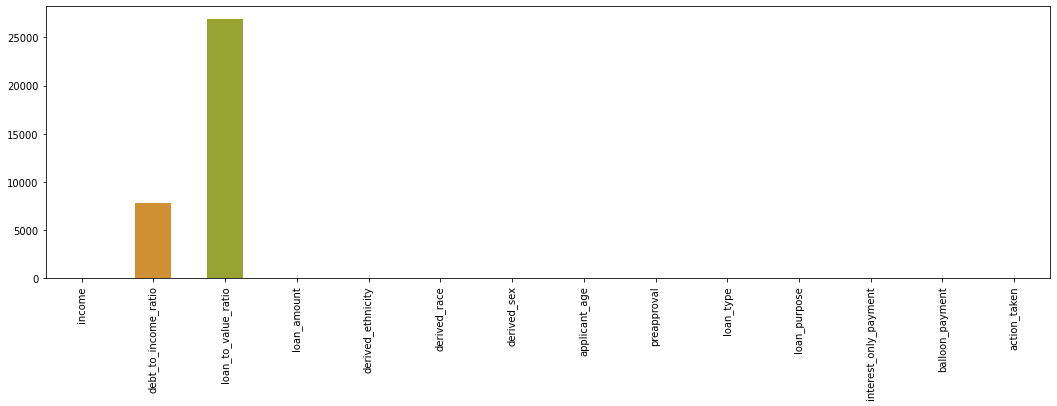

In [9]:
# Visualize missing values 
plt.figure(figsize = (18,5))
df.isnull().sum().plot(kind='bar',color=sns.color_palette("husl", 8))

In [10]:
# Drop missing values 
df = df.dropna()
df.shape

(411840, 14)

# 4. Exploratory Data Analysis

In [11]:
df.shape
df.describe()
df.head()

(411840, 14)

,income,loan_amount,preapproval,loan_type,loan_purpose,interest_only_payment,balloon_payment,action_taken
count,411840.000000,411840.000000,411840.000000,411840.000000,411840.000000,411840.000000,411840.000000,411840.000000
mean,91.785145,246246.406371,1.968272,1.376348,14.144695,1.964406,1.993119,0.838306
std,51.532378,144411.579778,0.175276,0.702144,14.992965,0.185276,0.082668,0.368170
min,1.000000,5000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,53.000000,145000.000000,2.000000,1.000000,1.000000,2.000000,2.000000,1.000000
50%,80.000000,215000.000000,2.000000,1.000000,1.000000,2.000000,2.000000,1.000000
75%,119.000000,325000.000000,2.000000,2.000000,31.000000,2.000000,2.000000,1.000000
max,270.000000,855000.000000,2.000000,4.000000,32.000000,2.000000,2.000000,1.000000


,income,debt_to_income_ratio,loan_to_value_ratio,loan_amount,derived_ethnicity,derived_race,derived_sex,applicant_age,preapproval,loan_type,loan_purpose,interest_only_payment,balloon_payment,action_taken
8578078,82.0,44,97.0,315000.0,Not Hispanic or Latino,White,Joint,35-44,2,2,1,2,2,1
14169566,200.0,48,75.0,555000.0,Not Hispanic or Latino,White,Joint,35-44,2,1,31,2,2,1
1981492,23.0,39,73.171,95000.0,Not Hispanic or Latino,White,Female,65-74,2,1,32,2,2,1
6045389,164.0,20%-<30%,74.969,605000.0,Not Hispanic or Latino,Joint,Joint,25-34,2,1,31,2,2,1
5745138,78.0,50%-60%,84.06299999999999,275000.0,Hispanic or Latino,White,Joint,35-44,2,2,31,2,2,1


#### Correlation Matrix

In [12]:
df.corr()

,income,loan_amount,preapproval,loan_type,loan_purpose,interest_only_payment,balloon_payment,action_taken
income,1.000000,0.628878,-0.006068,-0.158702,0.068972,0.013876,0.020189,0.158705
loan_amount,0.628878,1.000000,-0.013278,-0.040056,0.044977,0.071811,0.069377,0.114650
preapproval,-0.006068,-0.013278,1.000000,-0.024944,0.158704,-0.028271,-0.011717,-0.079501
loan_type,-0.158702,-0.040056,-0.024944,1.000000,-0.145107,0.100210,0.044533,-0.024781
loan_purpose,0.068972,0.044977,0.158704,-0.145107,1.000000,0.014441,0.003436,-0.115472
interest_only_payment,0.013876,0.071811,-0.028271,0.100210,0.014441,1.000000,0.296792,0.063174
balloon_payment,0.020189,0.069377,-0.011717,0.044533,0.003436,0.296792,1.000000,0.011070
action_taken,0.158705,0.114650,-0.079501,-0.024781,-0.115472,0.063174,0.011070,1.000000


#### Correlation Plot
This may show us relationships between protected attributes or variables masked as proxies for those protected attribtues.

<Figure size 1080x576 with 0 Axes>

<AxesSubplot:>

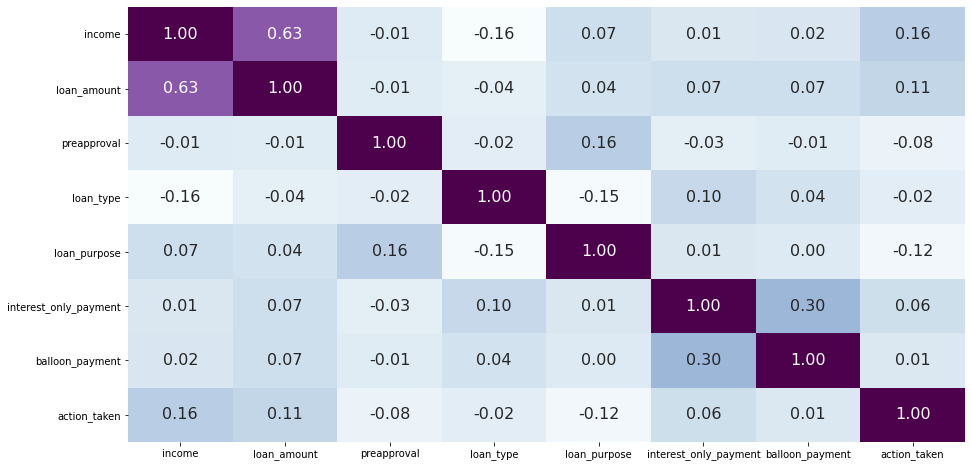

In [13]:
plt.figure(figsize=(15,8))
sns.heatmap(df.corr(),
           cmap='BuPu',
           annot=True,
           fmt=".2f",
           annot_kws={'size':16},
           cbar=False)

#### Check Correlations among Variables

In [14]:
correlations = df.corr()
correlations.replace(1,0).idxmax()

income                             loan_amount
loan_amount                             income
preapproval                       loan_purpose
loan_type                interest_only_payment
loan_purpose                       preapproval
interest_only_payment          balloon_payment
balloon_payment          interest_only_payment
action_taken                            income
dtype: object

<AxesSubplot:xlabel='income', ylabel='loan_amount'>

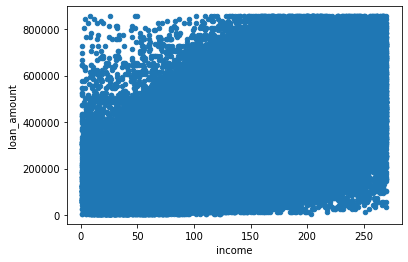

In [15]:
df[['income','loan_amount']].plot.scatter('income','loan_amount')

#### Check for Categorical Variables

In [16]:
cat_cols = df.loc[:,df.dtypes=='object'].columns
for column in cat_cols:
    print('Unique Values in ', column, df[column].unique())
    print(df[column].value_counts())

Unique Values in  debt_to_income_ratio ['44' '48' '39' '20%-<30%' '50%-60%' '30%-<36%' '47' '40' '38' '41' '>60%'
 '<20%' '49' '37' '36' '45' '43' '46' '42' 'Exempt']
20%-<30%    75405
30%-<36%    69976
50%-60%     33099
<20%        24705
44          17369
42          16364
>60%        15893
43          15236
40          15059
41          15009
39          14529
38          14007
49          13754
37          13634
36          13010
45          12034
48          11241
46          10814
47          10700
Exempt          2
Name: debt_to_income_ratio, dtype: int64
Unique Values in  loan_to_value_ratio ['97.0' '75.0' '73.171' ... '93.241' '103.406' '60.728']
80.0      46981
95.0      28015
96.5      27943
100.0     23145
90.0      15183
          ...  
60.887        1
94.914        1
32.751        1
82.001        1
38.777        1
Name: loan_to_value_ratio, Length: 58232, dtype: int64
Unique Values in  derived_ethnicity ['Not Hispanic or Latino' 'Hispanic or Latino' 'Ethnicity Not Availabl

#### Target: Loan Origination 
The target variable, the action taken, is highly imbalanced, with more of the dataset having loan origination outcomes. 

1    345248
0     66592
Name: action_taken, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


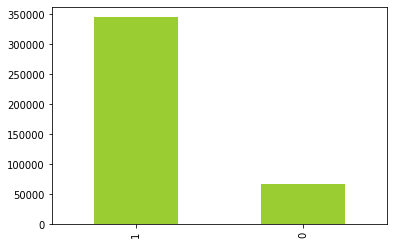

In [17]:
print(df['action_taken'].value_counts())
print(df['action_taken'].value_counts().plot(kind='bar',color="yellowgreen"))

#### Income
The income feature is skewed to the right, with more of the dataset having lower income levels. 

(array([ 3672., 13279., 38585., 51854., 56701., 47164., 42746., 32447.,
        29112., 21464., 16378., 14532., 10498.,  8579.,  6696.,  5375.,
         4020.,  3583.,  2840.,  2315.]),
 array([  1.  ,  14.45,  27.9 ,  41.35,  54.8 ,  68.25,  81.7 ,  95.15,
        108.6 , 122.05, 135.5 , 148.95, 162.4 , 175.85, 189.3 , 202.75,
        216.2 , 229.65, 243.1 , 256.55, 270.  ]),
 <BarContainer object of 20 artists>)

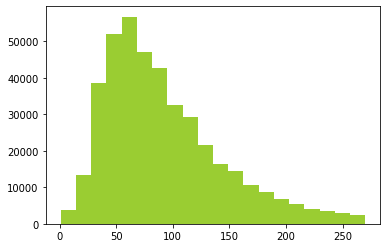

In [18]:
plt.hist(df['income'],bins = 20, color='yellowgreen')

#### Debt to Income Ratio
Bin the debt to income ratio feature 

In [19]:
def getDebtIncomeRatio(var):
    value = 'NaN'
    if (var)=='36':
        value = '36-39'
    elif (var)=='37':
        value = '36-39'
    elif (var)=='38':
        value = '36-39'
    elif (var)=='39':
        value = '36-39'
    elif (var)=='40':
        value = '40-45'
    elif (var)=='41':
        value = '40-45'
    elif (var)=='42':
        value = '40-45'
    elif (var)=='43':
        value = '40-45'
    elif (var)=='44':
        value = '40-45'
    elif (var)=='45':
        value = '40-45'
    elif (var)=='46':
        value = '46-49'   
    elif (var)=='47':
        value = '46-49'  
    elif (var)=='48':
        value = '46-49'  
    elif (var)=='49':
        value = '46-49'  
    else: 
        value = var
    return(value)

In [20]:
df['debt_to_income_ratio'] = df['debt_to_income_ratio'].apply(lambda x: getDebtIncomeRatio(x))
df['debt_to_income_ratio'].value_counts()

40-45       91071
20%-<30%    75405
30%-<36%    69976
36-39       55180
46-49       46509
50%-60%     33099
<20%        24705
>60%        15893
Exempt          2
Name: debt_to_income_ratio, dtype: int64

#### Loan to Value Ratio
The loan to value ratio feature is skewed to the right, with more of the dataset having lower debt to income ratios. 

(array([12155., 30890., 45780., 53347., 65411., 47212., 36990., 29971.,
        27399., 16374., 12702., 11406.,  6337.,  4140.,  3499.,  2652.,
         2853.,  1195.,   749.,   778.]),
 array([  5000.,  47500.,  90000., 132500., 175000., 217500., 260000.,
        302500., 345000., 387500., 430000., 472500., 515000., 557500.,
        600000., 642500., 685000., 727500., 770000., 812500., 855000.]),
 <BarContainer object of 20 artists>)

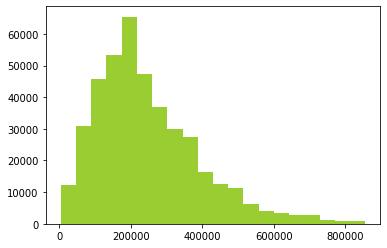

In [21]:
plt.hist(df['loan_amount'],bins = 20, color='yellowgreen')

#### Protected Classes

In [22]:
protectedClassCols = ['derived_ethnicity',
 'derived_race',
 'derived_sex',
 'applicant_age']

#### Ethnicity Categories
After filtering the dataset, the ethnicity break down: 

Not Hispanic or Latino     0.742774
Ethnicity Not Available    0.135914
Hispanic or Latino         0.100342
Joint                      0.020969
Name: derived_ethnicity, dtype: float64

AxesSubplot(0.125,0.125;0.775x0.755)


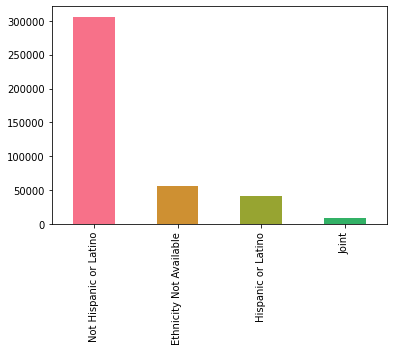

In [23]:
df['derived_ethnicity'].value_counts(normalize = True)
print(df['derived_ethnicity'].value_counts().plot(kind='bar',color=sns.color_palette("husl", 8)))

#### Race Categories
After filtering the dataset, the race demographic groups break down: 

White                                        0.712269
Race Not Available                           0.138493
Black or African American                    0.069364
Asian                                        0.052115
Joint                                        0.018772
American Indian or Alaska Native             0.004878
Native Hawaiian or Other Pacific Islander    0.002596
2 or more minority races                     0.001513
Name: derived_race, dtype: float64

AxesSubplot(0.125,0.125;0.775x0.755)


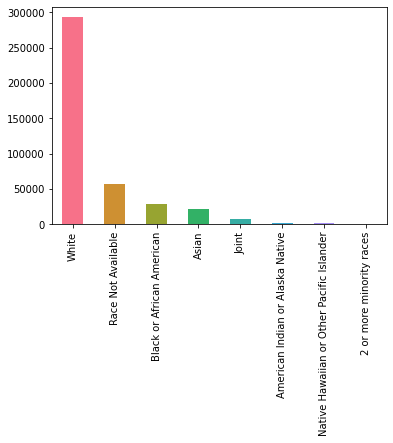

In [24]:
df['derived_race'].value_counts(normalize = True)
print(df['derived_race'].value_counts().plot(kind='bar',color=sns.color_palette("husl", 8)))

#### Sex Categories
After filtering the dataset, the sex categories break down: 

Joint                0.373458
Male                 0.326037
Female               0.225694
Sex Not Available    0.074811
Name: derived_sex, dtype: float64

AxesSubplot(0.125,0.125;0.775x0.755)


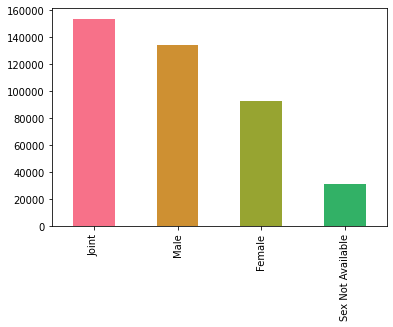

In [25]:
df['derived_sex'].value_counts(normalize = True)
print(df['derived_sex'].value_counts().plot(kind='bar',color=sns.color_palette("husl", 8)))

#### Age
After filtering the dataset, the age groups break down: 

35-44    0.240385
25-34    0.223196
45-54    0.201935
55-64    0.163923
65-74    0.100974
>74      0.035931
<25      0.033656
Name: applicant_age, dtype: float64

AxesSubplot(0.125,0.125;0.775x0.755)


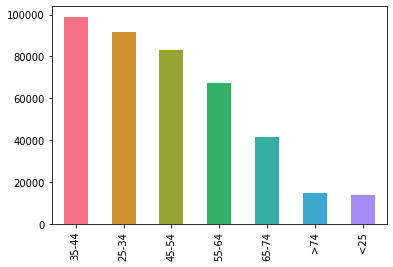

In [26]:
df['applicant_age'].value_counts(normalize = True)
print(df['applicant_age'].value_counts().plot(kind='bar',color=sns.color_palette("husl", 8)))

#### Loan Type 
After filtering the dataset, the loan types break down: 

1    0.737787
2    0.163092
3    0.084108
4    0.015013
Name: loan_type, dtype: float64

AxesSubplot(0.125,0.125;0.775x0.755)


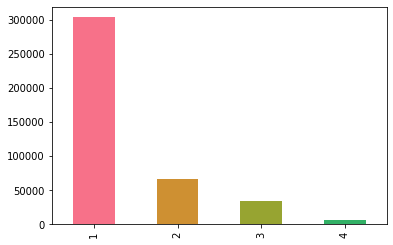

In [27]:
df['loan_type'].value_counts(normalize = True)
print(df['loan_type'].value_counts().plot(kind='bar',color=sns.color_palette("husl", 8)))

#### Loan Purpose 
After filtering the dataset, the loan_purpose groups break down: 

1     0.512634
31    0.215205
32    0.211844
4     0.030526
2     0.029791
Name: loan_purpose, dtype: float64

AxesSubplot(0.125,0.125;0.775x0.755)


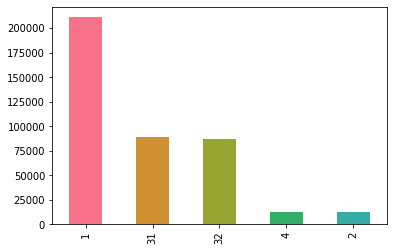

In [28]:
df['loan_purpose'].value_counts(normalize = True)
print(df['loan_purpose'].value_counts().plot(kind='bar',color=sns.color_palette("husl", 8)))

#### Interest Only Payments
After filtering the dataset, the interest only payment indicator break down: 

2    0.964406
1    0.035594
Name: interest_only_payment, dtype: float64

AxesSubplot(0.125,0.125;0.775x0.755)


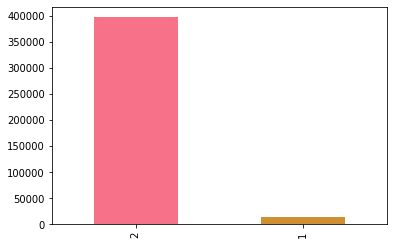

In [29]:
df['interest_only_payment'].value_counts(normalize = True)
print(df['interest_only_payment'].value_counts().plot(kind='bar',color=sns.color_palette("husl", 8)))

#### Balloon Payment Indicator
After filtering the dataset, the balloon payment indicator break down:

2    409006
1      2834
Name: balloon_payment, dtype: int64

AxesSubplot(0.125,0.125;0.775x0.755)


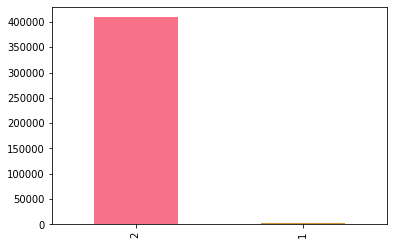

In [30]:
df['balloon_payment'].value_counts()
print(df['balloon_payment'].value_counts().plot(kind='bar',color=sns.color_palette("husl", 8)))

In [31]:
df.head()

,income,debt_to_income_ratio,loan_to_value_ratio,loan_amount,derived_ethnicity,derived_race,derived_sex,applicant_age,preapproval,loan_type,loan_purpose,interest_only_payment,balloon_payment,action_taken
8578078,82.0,40-45,97.0,315000.0,Not Hispanic or Latino,White,Joint,35-44,2,2,1,2,2,1
14169566,200.0,46-49,75.0,555000.0,Not Hispanic or Latino,White,Joint,35-44,2,1,31,2,2,1
1981492,23.0,36-39,73.171,95000.0,Not Hispanic or Latino,White,Female,65-74,2,1,32,2,2,1
6045389,164.0,20%-<30%,74.969,605000.0,Not Hispanic or Latino,Joint,Joint,25-34,2,1,31,2,2,1
5745138,78.0,50%-60%,84.06299999999999,275000.0,Hispanic or Latino,White,Joint,35-44,2,2,31,2,2,1


## 4.1 Exploratory Data Analysis Insights and Explanation 
*Add verbiage here about the data*


# 5. Data Preparation 

#### Map values in place
Mapping values in place is used instead of one hot encoding to perform the fairness assessment using IBM's AIF360 package.

##### Derived Ethnicity
- 0: Ethnicity Not Available
- 1: Hispanic or Latino 
- 2: Joint
- 3: Not Hispanic or Latino

##### Derived Race
- 0: Race not Available
- 1: 
- 2: Asian ?
- 3: Black or African American
- 4: Joint
- 5: 
- 6: Race not Available ?
- 7: White

##### Derived Sex
- 0: Female
- 1: Joint
- 2: Male
- 3: Sex not Available 

##### Derived Age
- 0: 25-34
- 1: 35-44?
- 2: 45-54?
- 3: 55-64
- 4: 65-74
- 5: <25?
- 6: >74

##### Debt to Income Ratio 
- 0: 20-30
- 1: 30-36
- 2: 36-39
- 3: 40-45
- 4: 46-49
- 5: 50-60

In [32]:
df['derived_ethnicity'] = df.derived_ethnicity.astype("category").cat.codes
df['derived_race'] = df.derived_race.astype("category").cat.codes
df['derived_sex'] = df.derived_sex.astype("category").cat.codes
df['applicant_age'] = df.applicant_age.astype("category").cat.codes
df['debt_to_income_ratio'] = df.debt_to_income_ratio.astype("category").cat.codes
df['loan_to_value_ratio'] = pd.to_numeric(df['loan_to_value_ratio'])
df.head()

,income,debt_to_income_ratio,loan_to_value_ratio,loan_amount,derived_ethnicity,derived_race,derived_sex,applicant_age,preapproval,loan_type,loan_purpose,interest_only_payment,balloon_payment,action_taken
8578078,82.0,3,97.000,315000.0,3,7,1,1,2,2,1,2,2,1
14169566,200.0,4,75.000,555000.0,3,7,1,1,2,1,31,2,2,1
1981492,23.0,2,73.171,95000.0,3,7,0,4,2,1,32,2,2,1
6045389,164.0,0,74.969,605000.0,3,4,1,0,2,1,31,2,2,1
5745138,78.0,5,84.063,275000.0,1,7,1,1,2,2,31,2,2,1


# 6. Split the Dataset into Training and Testing Sets
In this section I will define the target variable and features, apply a SMOTE data oversampling technique to minimize the effect of an imbalanced dataset, and split data into 70/30 segments.

In [33]:
# Define target and features
target = df['action_taken']
features = df.drop(['action_taken'], axis=1)

In [34]:
# Split into train/test while maintaining stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.30, random_state=42)

print('Number of data points in train data:', X_train.shape)
print('Number of data points in test data:', X_test.shape)

Number of data points in train data: (288288, 13)
Number of data points in test data: (123552, 13)


#### SMOTE Data Sampling 
A problem with imbalanced classification is that there are too few examples of the minority class for a model to effectively learn the decision boundary.

One way to solve this problem is to oversample the examples in the minority class. This can be achieved by simply duplicating examples from the minority class in the training dataset prior to fitting a model. This can balance the class distribution but does not provide any additional information to the model.

An improvement on duplicating examples from the minority class is to synthesize new examples from the minority class. This is a type of data augmentation for tabular data and can be very effective.

In [35]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

# 7. Create and Compare ML Classification Models

### XGBoost Model Grid Search
Create a XGBoost model with the best performing parameters from a grid search to classify individuals who are approved for a mortgage.

In [36]:
# # Comment out when XGBoost params have been identified
# # Create a XGBoost classifier 
# xgb_clf=xgb.XGBClassifier()

# # Define param grid to use random reach on 
# param_grid = {
#     'silent': [False],
#     'max_depth': [6, 10, 15, 20],
#     'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3], 
#     'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
#     'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
#     'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
#     'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
#     'gamma': [0, 0.25, 0.5, 1.0],
#     'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
#     'reg_alpha': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
#     'n_estimators': [100, 200, 400, 500, 1000],
#     'objective': ['binary:logistic']
# }

# fit_params = {'eval_metric': 'logloss',
#              'early_stopping_rounds': 10,
#              'eval_set':[(X_test, y_test)]}

# rs_clf = RandomizedSearchCV(xgb_clf, param_grid, n_iter = 20,
#                            n_jobs=-1, verbose=2, cv=3,
#                            scoring='neg_log_loss', refit=False, random_state=42)

# print("Randomized Search")
# rs_clf.fit(X_train, y_train, **fit_params)
# print('Randomized Search Complete')

# best_score = rs_clf.best_score_
# best_params = rs_clf.best_params_
# print("Best Score: {}".format(best_score))
# print("Best Params: ")

# for param_name in sorted(best_params.keys()):
#     print('%s: %r' % (param_name, best_params[param_name]))

### XGBoost Model
Apply the optimal hyperparameters to train the XGBoost classifier to classify individuals who are approved of a mortgage loan. Predict on the test set. 

In [ ]:
# Fit final model with best params
x_clf = XGBClassifier(colsample_bylevel= 0.5, colsample_bytree= 1.0, gamma= 0.0, learning_rate= 0.1, max_depth= 10, 
                      min_child_weight= 0.5, n_estimators= 200, objective= 'binary:logistic', reg_alpha= 0.1, 
                      reg_lambda= 1.0, silent= False, subsample= 1.0, eval_metrics='logloss',random_state=42)

x_clf.fit(X_train,y_train)

# Predict using test set
x_pred = x_clf.predict(X_test)
x_prob_pred = x_clf.predict_proba(X_test)[:,1]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[18:36:21] WARNING: ../src/learner.cc:576: 
Parameters: { "eval_metrics", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:36:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### SMOTE XGBoost Model
Apply the optimal hyperparameters to train the XGBoost classifier to classify individuals who are approved of a mortgage loan. Predict on the test set. 

In [ ]:
# Fit final model with best params
res_x_clf = XGBClassifier(colsample_bylevel= 0.5, colsample_bytree= 1.0, gamma= 0.0, learning_rate= 0.1, max_depth= 10, 
                      min_child_weight= 0.5, n_estimators= 200, objective= 'binary:logistic', reg_alpha= 0.1, 
                      reg_lambda= 1.0, silent= False, subsample= 1.0, eval_metrics='logloss',random_state=42)

res_x_clf.fit(X_res,y_res)

# Predict using test set
res_x_pred = res_x_clf.predict(X_test)
res_x_prob_pred = res_x_clf.predict_proba(X_test)[:,1]

### Random Forest Model
Create a Random Forest to classify individuals who are approved of a mortgage loan.

In [ ]:
# Fit final model with best params
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train,y_train)

# Predict using test set
rf_pred = rf_clf.predict(X_test)
rf_prob_pred = rf_clf.predict_proba(X_test)[:,1]

### SMOTE Random Forest Model
Create a Random Forest to classify individuals who are approved of a mortgage loan.

In [ ]:
# Fit final model with best params
res_rf_clf = RandomForestClassifier(random_state=42)
res_rf_clf.fit(X_res,y_res)

# Predict using test set
res_rf_pred = res_rf_clf.predict(X_test)
res_rf_prob_pred = res_rf_clf.predict_proba(X_test)[:,1]

### Logistic Regression Model
Create a Logistic Regression to classify individuals who are approved of a mortgage loan.

In [ ]:
# Fit final model with best params
lr_clf = LogisticRegression(random_state=42)
lr_clf.fit(X_train,y_train)

# Predict using test set
lr_pred = lr_clf.predict(X_test)
lr_prob_pred = lr_clf.predict_proba(X_test)[:,1]

### SMOTE Logistic Regression Model
Create a Logistic Regression to classify individuals who are approved of a mortgage loan.

In [ ]:
# Fit final model with best params
res_lr_clf = LogisticRegression(random_state=42)
res_lr_clf.fit(X_res,y_res)

# Predict using test set
res_lr_pred = res_lr_clf.predict(X_test)
res_lr_prob_pred = res_lr_clf.predict_proba(X_test)[:,1]

# 8. Model Evaluation Metrics

### Accuracy
Classification Accuracy is what we usually mean, when we use the term accuracy. It is the ratio of number of correct predictions to the total number of input samples.
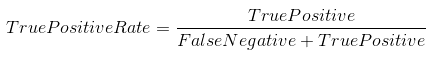 

### Sensitivity
True Positive Rate is defined as TP/ (FN+TP). True Positive Rate corresponds to the proportion of positive data points that are correctly considered as positive, with respect to all positive data points.
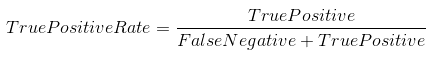

### Specificity 
True Negative Rate is defined as TN / (FP+TN). False Positive Rate corresponds to the proportion of negative data points that are correctly considered as negative, with respect to all negative data points.
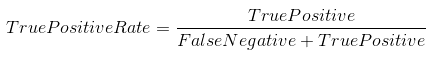

### Precision 
It is the number of correct positive results divided by the number of positive results predicted by the classifier.
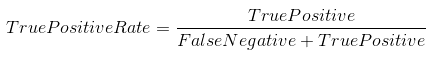

### F1 Score
F1 Score is the Harmonic Mean between precision and recall. F1 Score tries to find the balance between precision and recall. It tells you how precise your classifier is (how many instances it classifies correctly), as well as how robust it is (it does not miss a significant number of instances). High precision but lower recall, gives you an extremely accurate, but it then misses a large number of instances that are difficult to classify. 
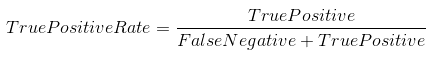


In [ ]:
# Create classification model eval method
def model_eval(y, prediction): 
    """
    Method to calculate model evaluation metrics to measure the effectiveness of the model. 
    
    :param y (numpy array): Train or test target values for ML model
    :param prediction (numpy array): Predictions from the ML model
    """
    accuracy = round(metrics.accuracy_score(y, prediction), 4)
    recall_sensitivity = round(metrics.recall_score(y, prediction), 4)
    recall_specificity = round(metrics.recall_score(y, prediction, pos_label=0), 4)
    precision_positive = round(metrics.precision_score(y, prediction), 4)
    precision_negative = round(metrics.precision_score(y, prediction, pos_label=0), 4)
    positive_f1_score = round(metrics.f1_score(y, prediction), 4)
    negative_f1_score = round(metrics.f1_score(y, prediction, pos_label=0), 4)
    
    model_eval_metrics = {'Accuracy': accuracy,
              'Sensitivity': recall_sensitivity,
              'Specificity': recall_specificity,
              'Precision Positive': precision_positive,
              'Precision Negative': precision_negative,
              'F1 Score Positive': positive_f1_score,
              'F1 Score Negative': negative_f1_score}
    
    return(model_eval_metrics)

# Call model evaluation metrics
x_results = model_eval(y_test, x_pred)
rf_results = model_eval(y_test, rf_pred)
lr_results = model_eval(y_test, lr_pred)
smote_x_results = model_eval(y_test, res_x_pred)
smote_rf_results = model_eval(y_test, res_rf_pred)
smote_lr_results = model_eval(y_test, res_lr_pred)

# Visualize model evaluation metrics in a heatmap 
xgbmodel = x_results
rfmodel = rf_results
lrmodel = lr_results
smote_xgbmodel = smote_x_results
smote_rfmodel = smote_rf_results
smote_lrmodel = smote_lr_results

viz = pd.DataFrame.from_dict(xgbmodel, orient='index', columns=['XGBoost'])
viz['Random Forest'] = pd.DataFrame.from_dict(rfmodel, orient='index', columns=['Random Forest'])
viz['Logistic Regression'] = pd.DataFrame.from_dict(lrmodel, orient='index', columns=['Logistic Regression'])
viz['SMOTE XGBoost'] = pd.DataFrame.from_dict(smote_xgbmodel, orient='index', columns=['SMOTE XGBoost'])
viz['SMOTE Random Forest'] = pd.DataFrame.from_dict(smote_rfmodel, orient='index', columns=['SMOTE Random Forest'])
viz['SMOTE Logistic Regression'] = pd.DataFrame.from_dict(smote_lrmodel, orient='index', columns=['SMOTE Logistic Regression'])

viz.head(10)
ax = sns.heatmap(viz,
                cmap = 'BuPu',
                linewidths = .5,
                annot = True)

## 8.1 Model Evaluation Explanation

*Update analysis below*

#### SMOTE Oversampling vs No Oversampling
Class imbalance is a common issue and if not handled can have a telling impact on the model performance and is especially critical for the minority class. As we can see from the results, the models that used a SMOTE oversampling technique had better accuracy for the minority class. However, overall the SMOTE models were less performant in all other model evaluation scores. For the purpose of this project, I will be selecting a model that uses the SMOTE oversampling technique because I'm interested in explaining the minority class. 

#### Logistic Regression vs Random Forest vs XGBoost
The logistic regression model performs less accurately and efficiently than the XGBoost and random forest models. The XGBoost and random forest models are highly complex algorithms that could potentially be complicated to understand or explain how the alogrithms make decisions. The logistic regression is less computationally heavy and can be explained better than the more complicated algorithms like xgboost and random forest. For the purpose of this project, I will be selecting the most performant model because I'm interested in explaining the accuracy overall. 

#### Final Model Selection
For the remaining analysis I will be using the <b>SMOTE XGBoost model</b>. It is the most performant of the models that used an oversampling technique. There are ultimately more factors when selecting a final model and I'll be exploring the fairness of the XGBoost model.  

# 9. Fairness Evaluation and Bias Detection
Fairness Detection Documentation: https://aif360.readthedocs.io/en/latest/modules/sklearn.html#module-aif360.sklearn.metrics 

### Individual vs. Group Fairness, or Both
Group fairness, in its broadest sense, partitions a population into groups defined by protected attributes and seeks for some statistical measure to be equal across groups.  Individual fairness, in its broadest sense, seeks for similar individuals to be treated similarly.  If the application is concerned with individual fairness, then the metrics in the SampleDistortionMetric class should be used.  If the application is concerned with group fairness, then the metrics in the DatasetMetric class (and in its children classes such as the BinaryLabelDatasetMetric class) as well as the ClassificationMetric class (except the ones noted in the next sentence) should be used.  If the application is concerned with both individual and group fairness, and requires the use of a single metric, then the generalized entropy index and its specializations to Theil index and coefficient of variation in the ClassificationMetric class should be used.  Of course, multiple metrics, including ones from both individual and group fairness can be examined simultaneously.

### Convert Test Data into a BinaryLabelDataset to Calculate ClassificationMetric Methods
Binary label datasets are the base class for all structured datasets with binary labels in the AIF360 library. Data must be converted to the BLD format in order to utilize the packages features and metrics. 

In [ ]:
# Construct the test dataframe 
test_df = pd.DataFrame(X_test)
test_df['action_taken'] = y_test

# Convert the test dataframe into a BinaryLabelDataset
bld_df = BinaryLabelDataset(favorable_label=1,
                            unfavorable_label=0,
                            df=test_df,
                            label_names=['action_taken'],
                            protected_attribute_names=['derived_race','derived_sex','derived_ethnicity'])

# Copy the test BinaryLabelDataset format and add the logistic regression predictions 
bld_df_pred = bld_df.copy()
bld_df_pred.labels = res_x_pred

# Initialize the unprivileged and privileged groups
unprivileged_groups = [{'derived_race':3}] # African American 
privileged_groups = [{'derived_race':7}] # Caucasian  

# Create the ClassificationMetric that will be used in fairness assessment 
clf_metric = ClassificationMetric(bld_df,
                                  bld_df_pred,
                                  unprivileged_groups,
                                  privileged_groups)

### HUD Fairness Assessment
In this section, I'll be conducting a fairness assessment. The goal is to detect bias and will be focussing on protected classes like race, sex, and other factors that could be proxies to protected attributes.

The first step in creating trustworthy AI is bias identification. Once algorithmic bias has been detected, data scientists can then take steps towards mitigating bias. With the help of open-source libraries, there are fairness measures available for evaluating models for unintentional bias. Below is the bias detection function that will be used to conduct the fairness assessment. It will also be used in the bias mitigation step to identify changes in bias. 

In [ ]:
def fairness_bias_detection(clf_metric):    
    metrics = {"Accuracy":clf_metric.accuracy(),
               "Disparate Impact":clf_metric.disparate_impact(),
               "Statistical Parity Difference":clf_metric.statistical_parity_difference(),
               "Equal Opportunity Difference":clf_metric.equal_opportunity_difference(),
               "Average Odds Difference":clf_metric.average_odds_difference(),
               "Theil Index":clf_metric.theil_index(),
               "False Positive Rate":clf_metric.false_positive_rate(),
               "False Negative Rate":clf_metric.false_negative_rate(),
               "False Omission Rate":clf_metric.false_omission_rate(),
               "False Discovery Rate":clf_metric.false_discovery_rate(),
               "Error Rate":clf_metric.error_rate(),
               "Differential Fairness Bias Amplification":clf_metric.differential_fairness_bias_amplification()}
    
    return(metrics)

In [ ]:
# Call fairness assessment metrics 
fair_assessment = fairness_bias_detection(clf_metric)

### Visualize Fairness Assessment: Bias Detection Metrics 

In [ ]:
fair_viz = pd.DataFrame.from_dict(fair_assessment, orient='index', columns=['SMOTE XGBoost Fairness Assessment'])
fair_viz = fair_viz.iloc[0:12]
fair_viz['SMOTE XGBoost Fairness Assessment'] = fair_viz['SMOTE XGBoost Fairness Assessment'].astype(float)
fair_viz.head(15)

fair_results = sns.heatmap(fair_viz,
                           cmap="BuPu",
                           linewidths=.5,
                           annot=True)

## Deep Dive into the Fairness Assessment: Group Fairness Metrics

### Disparate Impact 

Legal theory that states a practice is considered illegal discrimination if it has a “disproportionately adverse” effect on members of a protected group. “disproportionately adverse” is usually defined using the 80% Rule, otherwise known as the four fifths rule.

Disparate impact and the four fifths rule are directly related. Disparate impact is used in legal proceedings and can be typically found in law affecting employment policies. It enables challenges to policies that place a disproportionate burden on members of a protected class. It’s a way to prove employment discrimination and can be used to prove discrimination in other scenarios. The four fifths rule, also known as the 80% rule, is a guideline used to prove adverse effect on marginalized groups. The two bias detection techniques are typically used together to prove discrimination against protected groups.

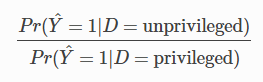

In [ ]:
clf_metric.disparate_impact()

### Four Fifths Rule
The Four-Fifths rule states that if the selection rate for a certain group is less than 80 percent of that of the group with the highest selection rate, there is adverse impact on that group. 

In [ ]:
# create a dataframe for bias detection   
bias_detect_df = test_df
bias_detect_df['pred'] = res_x_pred

#### Derived Race
- 0: Race not Available
- 1: 
- 2: Asian ?
- 3: Black or African American
- 4: Joint
- 5: 
- 6: Race not Available ?
- 7: White

*Add analysis here*

In [ ]:
# define race sub categories
race_na1 = bias_detect_df[bias_detect_df['derived_race']==0]
unknown1 = bias_detect_df[bias_detect_df['derived_race']==1]
asian = bias_detect_df[bias_detect_df['derived_race']==2]
african_american = bias_detect_df[bias_detect_df['derived_race']==3]
joint = bias_detect_df[bias_detect_df['derived_race']==4]
unknown2 = bias_detect_df[bias_detect_df['derived_race']==5]
race_na2 = bias_detect_df[bias_detect_df['derived_race']==6]
caucasian = bias_detect_df[bias_detect_df['derived_race']==7]

# calculate race sub category rates
rate_race_na1 = sum(race_na1['pred'])/len(race_na1)
rate_unknown1 = sum(unknown1['pred'])/len(unknown1)
rate_asian = sum(asian['pred'])/len(asian)
rate_african_american = sum(african_american['pred'])/len(african_american)
rate_joint = sum(joint['pred'])/len(joint)
rate_unknown2 = sum(unknown2['pred'])/len(unknown2)
rate_race_na2 = sum(race_na2['pred'])/len(race_na2)
rate_caucasian = sum(caucasian['pred'])/len(caucasian)

# print(rate_race_na1, rate_unknown1, rate_asian, rate_african_american, rate_joint, rate_unknown2, rate_race_na2, rate_caucasian)

# calculate race sub category ratio 
ratio_african_american = rate_african_american/rate_caucasian
ratio_race_na1 = rate_race_na1/rate_caucasian
ratio_unknown1 = rate_unknown1/rate_caucasian
ratio_asian = rate_asian/rate_caucasian
ratio_joint = rate_joint/rate_caucasian
ratio_unknown2 = rate_unknown2/rate_caucasian
ratio_race_na2 = rate_race_na2/rate_caucasian

# plot four fifths visualization for race sub categories
fig = plt.figure()
race_four_fifth = fig.add_axes([0,0,1,1])
classes = ['Caucasian','African American','Race NA1','Unknown1', 'Asian', 'Joint', 'Unknown2', 'Race NA2']
rates = [1, ratio_african_american, ratio_race_na1, ratio_unknown1, ratio_asian, ratio_joint, ratio_unknown2, ratio_race_na2]
race_four_fifth.bar(classes,rates,color=sns.color_palette("husl", 8))
race_four_fifth.set_ylabel('Relative Positive Classification Rates')
race_four_fifth.axhline(.8, ls='--', c='red')
plt.show()

#### Derived Sex
- 0: Female
- 1: Joint
- 2: Male
- 3: Sex not Available 

*Add analysis here*

In [ ]:
# define sex sub categories
female = bias_detect_df[bias_detect_df['derived_sex']==0]
joint = bias_detect_df[bias_detect_df['derived_sex']==1]
male = bias_detect_df[bias_detect_df['derived_sex']==2]
sex_na = bias_detect_df[bias_detect_df['derived_sex']==3]

# calculate sex sub category rates
rate_female = sum(female['pred'])/len(female)
rate_male = sum(male['pred'])/len(male)
rate_joint = sum(joint['pred'])/len(joint)
rate_sex_na = sum(sex_na['pred'])/len(sex_na)

# print(rate_female,rate_male,rate_joint,rate_sex_na)    

# calculate the sex sub category ratio
ratio_female = rate_female/rate_sex_na
ratio_male = rate_male/rate_sex_na
ratio_joint = rate_joint/rate_sex_na

# plot four fifths visualization for sex sub categories
fig = plt.figure()
sex_four_fifth = fig.add_axes([0,0,1,1])
classes = ['Sex NA', 'Female', 'Male', 'Joint']
rates = [1, ratio_female, ratio_male, ratio_joint]
sex_four_fifth.bar(classes,rates,color=sns.color_palette("husl", 8))
sex_four_fifth.set_ylabel('Relative Positive Classification Rates')
sex_four_fifth.axhline(.8, ls='--', c='red')
plt.show()

#### Derived Age
- 0: 25-34
- 1: 35-44?
- 2: 45-54?
- 3: 55-64
- 4: 65-74
- 5: <25?
- 6: >74

*Add analysis here*

In [ ]:
# define age sub categories
age_25_34 = bias_detect_df[bias_detect_df['applicant_age']==0]
age_35_44 = bias_detect_df[bias_detect_df['applicant_age']==1]
age_45_54 = bias_detect_df[bias_detect_df['applicant_age']==2]
age_55_64 = bias_detect_df[bias_detect_df['applicant_age']==3]
age_65_74 = bias_detect_df[bias_detect_df['applicant_age']==4]
age_young_25 = bias_detect_df[bias_detect_df['applicant_age']==5]
age_old_74 = bias_detect_df[bias_detect_df['applicant_age']==6]


# calculate age sub category rates
rate_age_25_34 = sum(age_25_34['pred'])/len(age_25_34)
rate_age_35_44 = sum(age_35_44['pred'])/len(age_35_44)
rate_age_45_54 = sum(age_45_54['pred'])/len(age_45_54)
rate_age_55_64 = sum(age_55_64['pred'])/len(age_55_64)
rate_age_65_74 = sum(age_65_74['pred'])/len(age_65_74)
rate_age_young_25 = sum(age_young_25['pred'])/len(age_young_25)
rate_age_old_74 = sum(age_old_74['pred'])/len(age_old_74)

# print(rate_age_25_34, rate_age_35_44, rate_age_45_54, rate_age_55_64, rate_age_65_74, rate_age_young_25, rate_age_old_74)    

# calculate age sub category ratio 
ratio_age_25_34 = rate_age_25_34/rate_age_young_25
ratio_age_35_44 = rate_age_35_44/rate_age_young_25
ratio_age_45_54 = rate_age_45_54/rate_age_young_25
ratio_age_55_64 = rate_age_55_64/rate_age_young_25
ratio_age_65_74 = rate_age_65_74/rate_age_young_25
ratio_age_old_74 = rate_age_old_74/rate_age_young_25

# plot four fifths visualization for age sub categories
fig = plt.figure()
age_four_fifth = fig.add_axes([0,0,1,1])
classes = ['< 25', '25-34', '35-44', '45-54', '55-64', '65-74', '> 74']
rates = [1, ratio_age_25_34, ratio_age_35_44, ratio_age_45_54, ratio_age_55_64, ratio_age_65_74, ratio_age_old_74]
age_four_fifth.bar(classes,rates,color=sns.color_palette("husl", 8))
age_four_fifth.set_ylabel('Relative Positive Classification Rates')
age_four_fifth.axhline(.8, ls='--', c='red')
plt.show()

#### Debt to Income Ratio 
- 0: 20-30
- 1: 30-36
- 2: 36-39
- 3: 40-45
- 4: 46-49
- 5: 50-60

*Add analysis here*

In [ ]:
# define debt to income ratio sub categories
dir_20_30 = bias_detect_df[bias_detect_df['debt_to_income_ratio']==0]
dir_30_36 = bias_detect_df[bias_detect_df['debt_to_income_ratio']==1]
dir_36_39 = bias_detect_df[bias_detect_df['debt_to_income_ratio']==2]
dir_40_45 = bias_detect_df[bias_detect_df['debt_to_income_ratio']==3]
dir_46_49 = bias_detect_df[bias_detect_df['debt_to_income_ratio']==4]
dir_50_60 = bias_detect_df[bias_detect_df['debt_to_income_ratio']==5]

# calculate debt to income ratio sub category rates
rate_dir_20_30 = sum(dir_20_30['pred'])/len(dir_20_30)
rate_dir_30_36 = sum(dir_30_36['pred'])/len(dir_30_36)
rate_dir_36_39 = sum(dir_36_39['pred'])/len(dir_36_39)
rate_dir_40_45 = sum(dir_40_45['pred'])/len(dir_40_45)
rate_dir_46_49 = sum(dir_46_49['pred'])/len(dir_46_49)
rate_dir_50_60 = sum(dir_50_60['pred'])/len(dir_50_60)

# print(rate_dir_20_30, rate_dir_30_36, rate_dir_36_39, rate_dir_40_45, rate_dir_46_49, rate_dir_50_60)    

# calculate debt to income ratio sub category ratio 
ratio_dir_20_30 = rate_dir_20_30/rate_dir_30_36
ratio_dir_36_39 = rate_dir_36_39/rate_dir_30_36
ratio_dir_40_45 = rate_dir_40_45/rate_dir_30_36
ratio_dir_46_49 = rate_dir_46_49/rate_dir_30_36
ratio_dir_50_60 = rate_dir_50_60/rate_dir_30_36

# plot four fifths visualization for debt to income ratio sub categories
fig = plt.figure()
age_four_fifth = fig.add_axes([0,0,1,1])
classes = ['30-36', '20-30', '36-39', '40-45', '46-49', '50-60']
rates = [1, ratio_dir_20_30, ratio_dir_36_39, ratio_dir_40_45, ratio_dir_46_49, ratio_dir_50_60]
age_four_fifth.bar(classes,rates,color=sns.color_palette("husl", 8))
age_four_fifth.set_ylabel('Relative Positive Classification Rates')
age_four_fifth.axhline(.8, ls='--', c='red')
plt.show()

### Statistical Parity Difference
The mathematical equivalence of the disparate impact principle at its most extreme version (allowing no adverse effect on members of the protected group) for binary classification tasks is the Statistical Parity condition: it essentially equalizes the outcomes across the protected and non-protected groups.

Statistical parity suggests that a predictor is unbiased if the prediction is independent of the protected attribute. Deviations from statistical parity are measured by the statistical parity difference which is what we will be using to identify statistical parity.

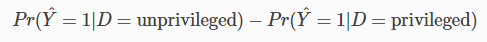


In [ ]:
clf_metric.statistical_parity_difference()

### Balance
The balance test examine whether the average score received by individuals in positive and negative instances are similar regardless of their protected attributes.

In [ ]:
# Add prediction probability to dataframe for balance calculation 
bias_detect_df['pred_prob'] = res_x_prob_pred
bias_detect_df.head()

#### Derived Ethnicity
- 0: Ethnicity Not Available
- 1: Hispanic or Latino 
- 2: Joint
- 3: Not Hispanic or Latino

The model tends to assign a higher probability of mortgage lending approvals to individuals whose ethnicity is defined as not hispanic or latino.

In [ ]:
# Calculate the average prediction probability for each prediction and ethnicity 
avg_pred_prob = bias_detect_df.groupby(['derived_ethnicity','pred'])['pred_prob'].mean()
ethnicity_balance = pd.DataFrame(avg_pred_prob)
ethnicity_balance = ethnicity_balance.reset_index()

# Convert race from numeric to string
ethnicity_balance.loc[0:1,['derived_ethnicity']] = 'Ethnicity N/A'
ethnicity_balance.loc[2:3,['derived_ethnicity']] = 'Hispanic or Latino'
ethnicity_balance.loc[4:5,['derived_ethnicity']] = 'Joint'
ethnicity_balance.loc[6:7,['derived_ethnicity']] = 'Not Hispanic or Latino'

sns.barplot(x='pred',y='pred_prob',hue='derived_ethnicity',data=ethnicity_balance, palette=sns.color_palette("husl", 8)).set_title('Balance of Predictions for Each Ethnicity')

#### Derived Race
- 0: Race not Available
- 1: 
- 2: Asian ?
- 3: Black or African American
- 4: Joint
- 5: 
- 6: Race not Available ?
- 7: White

The model tends to assign a higher probability of mortgage lending approvals to individuals whose race is defined as white.

In [ ]:
# Calculate the average prediction probability for each prediction and race 
avg_pred_prob = bias_detect_df.groupby(['derived_race','pred'])['pred_prob'].mean()
race_balance = pd.DataFrame(avg_pred_prob)
race_balance = race_balance.reset_index()

# Convert sex from numeric to string
race_balance.loc[0:1,['derived_race']] = 'Race N/A'
race_balance.loc[2:3,['derived_race']] = 'Unknown'
race_balance.loc[4:5,['derived_race']] = 'Asian'
race_balance.loc[6:7,['derived_race']] = 'Black or African American'
race_balance.loc[8:9,['derived_race']] = 'Joint'
race_balance.loc[10:11,['derived_race']] = 'Unknown'
race_balance.loc[12:13,['derived_race']] = 'Race N/A'
race_balance.loc[14:15,['derived_race']] = 'White'

sns.barplot(x='pred',y='pred_prob',hue='derived_race',data=race_balance, palette=sns.color_palette("husl", 8)).set_title('Balance of Predictions for Each Race')

#### Derived Sex
- 0: Female
- 1: Joint
- 2: Male
- 3: Sex not Available

The model tends to assign a higher probability of mortgage lending approvals to individuals whose sex is defined as male or unknown.

In [ ]:
# Calculate the average prediction probability for each prediction and sex 
avg_pred_prob = bias_detect_df.groupby(['derived_sex','pred'])['pred_prob'].mean()
sex_balance = pd.DataFrame(avg_pred_prob)
sex_balance = sex_balance.reset_index()

# Convert poverty from numeric to string
sex_balance.loc[0:1,['derived_sex']] = 'Female'
sex_balance.loc[2:3,['derived_sex']] = 'Joint'
sex_balance.loc[4:5,['derived_sex']] = 'Male'
sex_balance.loc[6:7,['derived_sex']] = 'Sex Not Available'

sns.barplot(x='pred',y='pred_prob',hue='derived_sex',data=sex_balance, palette=sns.color_palette("husl", 8)).set_title('Balance of Predictions for Each Sex')

#### Derived Age
- 0: 25-34
- 1: 35-44?
- 2: 45-54?
- 3: 55-64
- 4: 65-74
- 5: <25?
- 6: >74

The model tends to assign a higher probability of mortgage lending approvals to individuals whose age group is defined as younger than 25 years old.

In [ ]:
# Calculate the average prediction probability for each prediction and age 
avg_pred_prob = bias_detect_df.groupby(['applicant_age','pred'])['pred_prob'].mean()
age_balance = pd.DataFrame(avg_pred_prob)
age_balance = age_balance.reset_index()

# age_balance.head(40)

# Convert poverty from numeric to string
age_balance.loc[0:1,['applicant_age']] = '25-34'
age_balance.loc[2:3,['applicant_age']] = '35-44'
age_balance.loc[4:5,['applicant_age']] = '45-54'
age_balance.loc[6:7,['applicant_age']] = '55-64'
age_balance.loc[8:9,['applicant_age']] = '65-74'
age_balance.loc[10:11,['applicant_age']] = '< 25'
age_balance.loc[12:13,['applicant_age']] = '> 74'

sns.barplot(x='pred',y='pred_prob',hue='applicant_age',data=age_balance, palette=sns.color_palette("husl", 8)).set_title('Balance of Predictions for Each Age Group')

#### Debt to Income Ratio 
- 0: 20-30
- 1: 30-36
- 2: 36-39
- 3: 40-45
- 4: 46-49
- 5: 50-60

The model tends to assign a higher probability of mortgage lending approvals to individuals whose debt to income ratio group is defined as 20% - 30%.

In [ ]:
# Calculate the average prediction probability for each prediction and dir group 
avg_pred_prob = bias_detect_df.groupby(['debt_to_income_ratio','pred'])['pred_prob'].mean()
dir_balance = pd.DataFrame(avg_pred_prob)
dir_balance = dir_balance.reset_index()

# Convert poverty from numeric to string
dir_balance.loc[0:1,['debt_to_income_ratio']] = '20-30'
dir_balance.loc[2:3,['debt_to_income_ratio']] = '30-36'
dir_balance.loc[4:5,['debt_to_income_ratio']] = '36-39'
dir_balance.loc[6:7,['debt_to_income_ratio']] = '40-45'
dir_balance.loc[8:9,['debt_to_income_ratio']] = '46-49'
dir_balance.loc[10:11,['debt_to_income_ratio']] = '50-60'


sns.barplot(x='pred',y='pred_prob',hue='debt_to_income_ratio',data=dir_balance, palette=sns.color_palette("husl", 8)).set_title('Balance of Predictions for Each Debt ot Income Ratio Level')

### Equal Opportunity Difference
Equal opportunity is the idea that all people are given an equitable chance in order to ensure fairness. Algorithms that lack equitable opportunities can exacerbate discrimination in already marginalized groups and can foster social exclusion. Using the difference in recall scores between unprivileged and privileged groups can calculate the equality of how the subclasses of protected attributes are treated by algorithms. 

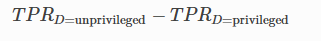

In [ ]:
clf_metric.equal_opportunity_difference()

### Average Odds Difference
The average odds difference is the average of difference in false positive rates and true positive rates between unpriviliged and privileged groups. A value of 0 implies both groups have equal benefit. 

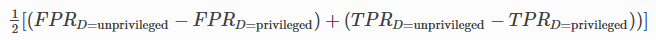

In [ ]:
clf_metric.average_odds_difference()

## Individual Fairness

### Theil Index
The Theil index is a statistic used to measure economic inequality. The Theil index measures entropic distance the population is away from the ideal egalitarian state of everyone having the same income. the numerical result is in terms of negative entropy so that a higher number indicates more order that is further away from the ideal of maximum disorder. Forumulating the index to represent negative entropy instead of entropy allows it to be a measure of inequality rather than equality.

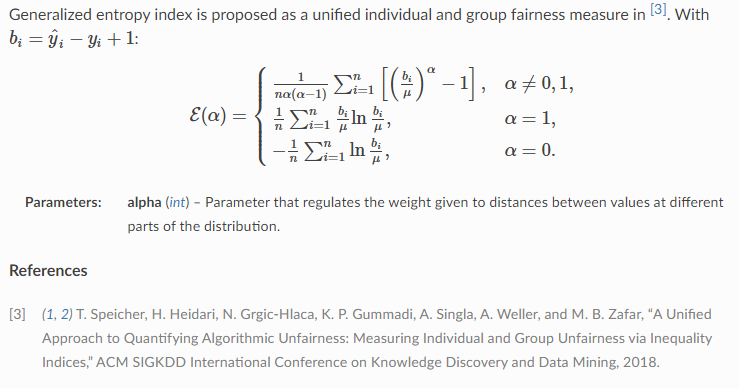

In [ ]:
clf_metric.theil_index()

### False Positive Rate
The false positive rate is the proportion of the individuals with a known negative condition for which the test result is positive. This rate is sometimes called the fall-out. 

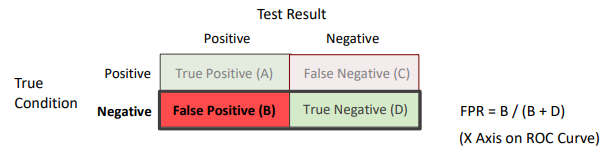

In [ ]:
clf_metric.false_positive_rate()

### False Negative Rate
The false negative rate is the proportion of the individuals with a known positive condition for which the testresult is negative. This rate is sometimes called the miss rate. 
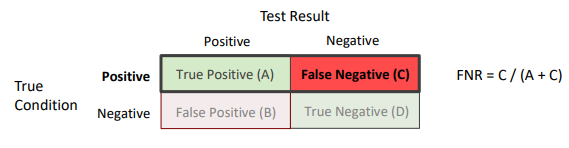

In [ ]:
clf_metric.false_negative_rate()

### False Omission Rate
The false omission rate is the proportion of the individuals with a negative test result for which the true condition
is positive. 

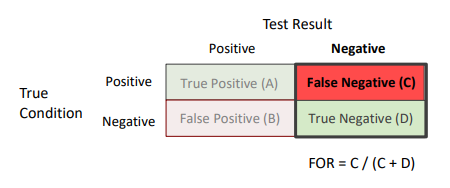

In [ ]:
clf_metric.false_omission_rate()

### False Discovery Rate
The false discovery rate is the proportion of the individuals with a positive test result for which the true condition is negative.

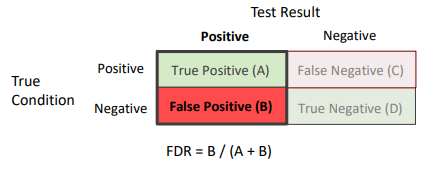

In [ ]:
clf_metric.false_discovery_rate()

### Error Rate
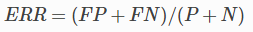

In [ ]:
clf_metric.error_rate()

### Accuracy
The accuracy reflects the total proportion of individuals that are correctly classified.

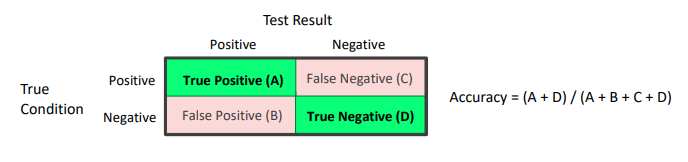

In [ ]:
clf_metric.accuracy()

### Differential Fairness Bias Amplification
Bias amplification is the difference in smoothed EDF between the classifier and the original dataset.

In [ ]:
clf_metric.differential_fairness_bias_amplification()

### Binary Confusion Matrix
Computes the number of true/false positives/negatives, optionally conditioned on protected attributes.



In [ ]:
clf_metric.binary_confusion_matrix()

## 9.1 Bias Identification Explanation
#### Fairness Metrics
*Add analysis here*


#### Four Fifths Analysis

*Add analysis here*

# 10. Mitigating Bias
To mitigate bias, I utilized an open-source toolkit/Python package of metrics and algorithms introduced by IBM Research in 2018. Bias mitigation algorithms can be generally categorized into three categories: pre-process (which affects the data, prior to training), in-process (which affects the classifier itself), and post-process (which affects the prediction labels that are output). 

Bias mitigation algorithms attempt to improve the fairness metrics by modifying the training data, the learning algorithm, or the predictions. These algorithm categories are known as pre-processing, in-processing, and post-processing, respectively. Bias mitigation algorithms attempt to improve algorithmic fairness by modifying the training data, the learning algorithm, or predictions. These algorithm categories are known as pre-processing, in-processing, and post-processing. Debiasing is a complex technique that cannot be applied for all problems in the same way. With the use of the pre, in, and post-processing debiasing techniques, comes with the risk of losing interpretability of the model. 


### Bias Mitigation with Pre-Processing
One approach for mitigating bias that some people often suggest is simply to remove the feature that should be protected. For example, if you are concerned of a model being sexist and you have gender available in your data set, remove it from the features passed to the machine learning algorithm. Unfortunately, this rarely fixes the problem. 

Pre-processing algorithms can be used to mitigate algorithmic bias. Pre-processing algorithms are applied prior to training the model. There are many pre-processing techniques but the most common and widely used are reweighing and applying a disparate impact remover. Reweighing is a technique that generates weights for labels differently to ensure fairness before fitting a classification model. The disparate impact remover is a variable repair technique. It modifies feature values to increase group fairness while preserving rank-ordering within groups.

In [ ]:
# Disparate impact remover preprocessing 
di = DisparateImpactRemover(repair_level = 1.0)
dataset_transf_train = di.fit_transform(bld_df)
transformed = dataset_transf_train.convert_to_dataframe()[0]

#### Retrain the SMOTE XGBoost Model

In [ ]:
x_trans = transformed.drop(['action_taken'], axis = 1)
y_trans = transformed['action_taken']

scaler = StandardScaler()
data_std = scaler.fit_transform(x_trans)
X_trans_train,X_trans_test,y_trans_train,y_trans_test = train_test_split(x_trans, y_trans, test_size=0.3, random_state = 42)

res_x_clf.fit(X_trans_train,y_trans_train)

# # Predict using test set
pre_res_x_pred = res_x_clf.predict(X_trans_test)
pre_res_x_prob_pred = res_x_clf.predict_proba(X_trans_test)[:,1]

#### Model Evaluation Results: SMOTE XGBoost Model using PreProcessing Disparate Impact Remover Technique

In [ ]:
# Call model evaluation metrics
pre_results = model_eval(y_trans_test, pre_res_x_pred)
smote_x_results = model_eval(y_test, res_x_pred)

# Visualize model evaluation metrics in a heatmap 
results = pre_results
smote_xgbmodel = smote_x_results


viz = pd.DataFrame.from_dict(results, orient='index', columns=['SMOTE XGBoost PreProcessing'])
viz['SMOTE XGBoost'] = pd.DataFrame.from_dict(smote_xgbmodel, orient='index', columns=['SMOTE XGBoost'])

viz.head(10)
ax = sns.heatmap(viz,
                cmap = 'BuPu',
                linewidths = .5,
                annot = True)

#### Fairness Results: SMOTE XGBoost Model using PreProcessing Disparate Impact Remover Technique

In [ ]:
# Construct the test dataframe 
trans_test_df = pd.DataFrame(X_trans_test)
trans_test_df['action_taken'] = y_trans_test

# Convert the test dataframe into a BinaryLabelDataset
bld_df = BinaryLabelDataset(favorable_label=1,
                            unfavorable_label=0,
                            df=trans_test_df,
                            label_names=['action_taken'],
                            protected_attribute_names=['derived_race','derived_sex','derived_ethnicity'])

# Copy the test BinaryLabelDataset format and add the logistic regression predictions 
bld_df_pred = bld_df.copy()
bld_df_pred.labels = pre_res_x_pred

# Initialize the unprivileged and privileged groups
unprivileged_groups = [{'derived_race':3}] # African American 
privileged_groups = [{'derived_race':7}] # Caucasian  

# Create the ClassificationMetric that will be used in fairness assessment 
trans_clf_metric = ClassificationMetric(bld_df,
                                    bld_df_pred,
                                    unprivileged_groups,
                                    privileged_groups)

In [ ]:
# Call fairness assessment metrics 
preproc_fair_assessment = fairness_bias_detection(trans_clf_metric)
fair_assessment = fairness_bias_detection(clf_metric)

fair_viz = pd.DataFrame.from_dict(preproc_fair_assessment, orient='index', columns=['Preprocessing SMOTE XGBoost Fairness Assessment'])
fair_viz['Preprocessing SMOTE XGBoost Fairness Assessment'] = fair_viz['Preprocessing SMOTE XGBoost Fairness Assessment'].astype(float)
fair_viz['SMOTE XGBoost Fairness Assessment'] = pd.DataFrame.from_dict(fair_assessment, orient='index', columns=['SMOTE XGBoost Fairness Assessment'])
fair_viz.head(15)

fair_results = sns.heatmap(fair_viz,
                           cmap="BuPu",
                           linewidths=.5,
                           annot=True)

## 10.1 Preprocessing Bias Mitigation Results Explanation 
Preprocessing algorithms like the disparate impact remover are used to mitigate bias. From knowledge of bias within ML, a fairness through unawareness approach can never fully mitigate bias like an algorithm can. Fairness though unawareness is a technique where protected attributes like race, age, and sex are removed from the model. However, typically bias will still remain. The disparate impact remover preprocessing bias mitigation technique can be applied to the training data and used when fitting and predicting a new model. 

From understanding the results of applying the disparate impact remover to the newly trained ‘fair’ SMOTE XGBoost model, we can see the ‘fair’ model performs better in several of the model evaluation categories like overall accuracy and in predicting the negative class. However, the newly trained ‘fair’ model has a harder time predicting the positive class where the previous model excelled. This may come as an interesting conclusion. Logically it makes more sense if the ‘fair’ model performs better at every model evaluation category than the original model. However, there is a trade-off between accuracy and fairness. When algorithms are built for accuracy needs, they typically don’t pay mind to perpetuating potential bias. When algorithms are built with fairness in mind, they are less accurate than if they had exploited the bias. While although there is no right way to handle the accuracy and fairness trade off, there are tools that can help data scientists optimize their models for a level of accuracy and fairness they’re comfortable implementing.  

The fairness results of the ‘fair’ model and the original SMOTE XGBoost model indicate that the model’s fairness improved with the disparate impact remover technique. The disparate impact the model has on marginalized groups decreased, the overall accuracy increased, and many of the other metrics improved within the ‘fair’ model. However, there is still bias that remains, which we can see with the increase of the differential fairness bias amplification and Theil index. While although the fairness improved in some ways, it is ultimately a judgement call on which model to choose for final implementation. 


### Bias Mitigation with Post-Processing
Post-processing algorithms are bias mitigation strategies to build accurate performing models while ensuring models are less discriminant. Post-processing algorithms are applied after training the model. There are several post-processing techniques but the most used are the equalized odds post-processing and calibrated equalized odds post-processing techniques. The equalized odds technique solves a linear program to find probabilities with which to change output labels to optimize equalized odds. Calibrated equalized odds postprocessing optimizes over calibrated classifier score outputs to find probabilities with which to change output labels with an equalized odds objective.

#### Calibrated Equalized Odds Post-Processing

In [ ]:
# Construct the test dataframe 
test_df = pd.DataFrame(X_test)
test_df['action_taken'] = y_test

# Convert the test dataframe into a BinaryLabelDataset
bld_df = BinaryLabelDataset(favorable_label=1,
                            unfavorable_label=0,
                            df=test_df,
                            label_names=['action_taken'],
                            protected_attribute_names=['derived_race','derived_sex','derived_ethnicity'])

# Copy the test BinaryLabelDataset format and add the logistic regression predictions 
bld_df_pred = bld_df.copy()
bld_df_pred.labels = res_x_pred

In [ ]:
cost_constraint='weighted'
# Learn parameters to equalize odds and apply to create a new dataset
copost = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups,
                                     unprivileged_groups = unprivileged_groups,
                                     cost_constraint=cost_constraint,
                                     seed=42)

copost = copost.fit(bld_df, bld_df_pred)
data_transf_test_pred = copost.predict(bld_df_pred)
post_res_x_pred=data_transf_test_pred.labels

#### Model Evaluation Results: SMOTE XGBoost Model using PostProcessing Calibrated Equalized Odds Technique

In [ ]:
# Convert the test dataframe into a BinaryLabelDataset
bld_df = BinaryLabelDataset(favorable_label=1,
                            unfavorable_label=0,
                            df=test_df,
                            label_names=['action_taken'],
                            protected_attribute_names=['derived_race','derived_sex', 'derived_ethnicity'])

# Copy the test BinaryLabelDataset format and add the logistic regression predictions 
bld_df_pred = bld_df.copy()
bld_df_pred.labels = post_res_x_pred

# Initialize the unprivileged and privileged groups
unprivileged_groups = [{'derived_race':3}] # African American 
privileged_groups = [{'derived_race':7}] # Caucasian  

# Create the ClassificationMetric that will be used in fairness assessment 
post_clf_metric = ClassificationMetric(bld_df,
                                        bld_df_pred,
                                        unprivileged_groups,
                                        privileged_groups)

In [ ]:
# Call fairness assessment metrics 
postproc_fair_assessment = fairness_bias_detection(post_clf_metric)

fair_viz = pd.DataFrame.from_dict(postproc_fair_assessment, orient='index', columns=['Postprocessing SMOTE XGBoost Fairness Assessment'])
fair_viz['Postprocessing SMOTE XGBoost Fairness Assessment'] = fair_viz['Postprocessing SMOTE XGBoost Fairness Assessment'].astype(float)
fair_viz['Preprocessing SMOTE XGBoost Fairness Assessment'] = pd.DataFrame.from_dict(preproc_fair_assessment, orient='index', columns=['Preprocessing SMOTE XGBoost Fairness Assessment'])
fair_viz['SMOTE XGBoost Fairness Assessment'] = pd.DataFrame.from_dict(fair_assessment, orient='index', columns=['SMOTE XGBoost Fairness Assessment'])

fair_viz.head(15)

fair_results = sns.heatmap(fair_viz,
                           cmap="BuPu",
                           linewidths=.5,
                           annot=True)

## 10.2 Postprocessing Bias Mitigation Results Explanation
Postprocessing algorithms like the calibrated equalized odds technique are used to mitigate bias after a model has been trained. There is often debate surrounding which processing technique is better to use. Often, postprocessing techniques rarely remove bias from an already trained model and instead remove bias from the outcomes. Refer to Figure 8 on the next page. 
The results of applying the calibrated equalized odds postprocessing bias mitigation technique show that the postprocessing model improved overall accuracy, Theil index, false discovery rate, and false omission rate. However, it did not perform as well as the preprocessing ‘fair’ model or original SMOTE XGBoost model in differential fairness bias amplification or disparate impact. 

While although each technique improved model fairness, there is no concise answer as to which technique subjectively improved fairness overall. 


# 11. Explain Model Predictions
The first step in explaining the model's predictions is to create an explainer. We can use SHAP Tree explainer, which is the main explainer used for tabular data for tree based problems. SHAP uses feature importance and shapley values that are an adaptation of game theory.  SHAP scales and generates new data using locality and computes statistics like mean for numerical data and frequency for categorical data, due to this we need to pass our training data as a parameter.

In [ ]:
# Explain predictions using the SHAP TreeExplainer
shap.initjs()
explainer = shap.TreeExplainer(res_x_clf)
shap_values = explainer.shap_values(X_res)

#### Local Explainability: Visualize a Single Prediction 

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_res.iloc[0,:])

#### Local Explainability: Visualize 1,000 Predictions 

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X_res.iloc[:1000,:])

#### Gloabl Explainability: Bar Chart Mean of Feature Importance

In [ ]:
shap.summary_plot(shap_values, X_res, plot_type="bar")

#### Global Explainability: Summary Density Scatter Feature Importance
Rather than use a typical feature importance bar chart, we can use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples. Note that when the scatter points don’t fit on a line they pile up to show density, and the color of each point represents the feature value of that individual.

In [ ]:
shap.summary_plot(shap_values, X_res)

#### Local Explainability: Dependence Plots
Dependence plots show the effect of a single feature across the whole dataset. They plot a feature’s value vs. the SHAP value of that feature across many samples. SHAP dependence plots are similar to partial dependence plots, but account for the interaction effects present in the features, and are only defined in regions of the input space supported by data. The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature is chosen for coloring to highlight possible interactions.

In [ ]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X_res, display_features=X_res)

In [ ]:
explainer = shap.Explainer(res_x_clf, X_res)
shap_values = explainer(X_res[:1000])

#### Heatmap

In [ ]:
shap.plots.heatmap(shap_values, max_display=20)

#### Local Explainability: Dependence Scatter Plot

In [ ]:
shap.plots.scatter(shap_values[:,'derived_race'],color=shap_values)

#### Local Explainability: Waterfall Plot

In [ ]:
shap.plots.waterfall(shap_values[0])

## 11.1 Explain Interpetable Model Results
The goal of explainable AI is to ensure all participants in the ML model lifecycle can understand how AI algorithms and AI system make decisions. Often times, black box algorithms are used to derive insights. Algorithms vary from simple to understand and explain to complicated models. Which is why transparency into decision making is important. 

*Add analysis here*

# 12. Mortgage Lending Summary

*Add analysis here*